In [1]:
import os
import cv2
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import pandas as pd
import dlib
import tensorflow as tf
from skimage.feature import local_binary_pattern

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Feature Extraction

## Tokenization

In [4]:
# Given sentences
sentences = [
    ['जल्दी', 'से', 'नारंगी', 'रंग', 'का', 'दुपट्टा', 'पहनो', 'फिर', 'चलते', 'हैं'],
    ['सावधानी', 'से', 'लाल', 'रंग', 'की', 'टैक्सी', 'को', 'रास्ता', 'दो', 'यात्री', 'उतर', 'रहे', 'हैं'],
    ['धीरे', 'से', 'गुलाबी', 'रंग', 'के', 'कप', 'को', 'चाय', 'से', 'भर', 'दो', 'ठंडा', 'हो', 'जाएगा'],
    ['गौर', 'से', 'सफ़ेद', 'रंग', 'के', 'फूल', 'को', 'देखो', 'क्या', 'यह', 'खिल', 'गया', 'हैं'],
    ['जल्दी', 'से', 'हरी', 'शर्ट', 'पहनो', 'फिर', 'कॉफी', 'पीकर', 'चलते', 'हैं'],
    ['सावधानी', 'से', 'पीली', 'स्कूल', 'बस', 'को', 'रास्ता', 'दो', 'बच्चे', 'रास्ता', 'पार', 'कर', 'रहे', 'हैं'],
    ['गौर', 'से', 'हरे', 'रंग', 'का', 'फल', 'देखो', 'क्या', 'यह', 'पका', 'हुआ', 'हैं'],
    ['जल्दी', 'से', 'चाय', 'बनाओ', 'फिर', 'बात', 'करते', 'हैं'],
    ['सावधानी', 'से', 'बर्तन', 'धोलो', 'नहीं', 'तो', 'माँ', 'डांटेंगी'],
    ['गलती', 'से', 'कागज़', 'को', 'दो', 'टुकड़ों', 'में', 'मत', 'काट', 'देना'],
    ['जल्दी', 'से', 'एक', 'हरा', 'सेब', 'खा', 'लो'],
    ['क्या', 'रसोई', 'में', 'नौ', 'लाल', 'मिर्च', 'हैं'],
    ['नीले', 'आसमान', 'में', 'पांच', 'पतंग', 'ऊंची', 'उड़', 'रही', 'हैं'],
    ['नीले', 'बैग', 'में', 'पांच', 'सेब', 'जल्दी', 'से', 'रखें'],
    ['मेरे', 'फोन', 'पर', 'जोर', 'से', 'पांच', 'बार', 'रिंग', 'करें'],
    ['चावल', 'के', 'साथ', 'चार', 'सब्जियां', 'मिलाएं'],
    ['सारे', 'पौधों', 'में', 'पानी', 'डालने', 'के', 'लिए', 'तीन', 'लीटर', 'पानी', 'की', 'आवश्यकता', 'हैं'],
    ['दो', 'केले', 'खाने', 'के', 'बाद', 'पानी', 'न', 'पियें'],
    ['हरे', 'पार्क', 'में', 'तीन', 'किलोमीटर', 'तेज', 'चलें'],
    ['लाल', 'टमाटर', 'के', 'साथ', 'तीन', 'प्याज', 'बारीक', 'काट', 'लें'],
    ['काले', 'जूतों', 'को', 'साफ', 'करने', 'के', 'लिए', 'तीन', 'मिनट', 'तक', 'ब्रश', 'करें'],
]

# Initialize an empty set to collect unique words
vocab_set = set()

# Iterate through each sentence to collect unique words
for sentence in sentences:
    # Iterate through each word in the sentence and add it to the set
    for word in sentence:
        vocab_set.add(word)

# Convert the set to a list
vocab = list(vocab_set)

# Convert the set to a sorted list
vocab.sort()

# Print the vocabulary list
print("The vocabulary is:", vocab)

The vocabulary is: ['आवश्यकता', 'आसमान', 'उड़', 'उतर', 'ऊंची', 'एक', 'कप', 'कर', 'करते', 'करने', 'करें', 'का', 'कागज़', 'काट', 'काले', 'किलोमीटर', 'की', 'के', 'केले', 'कॉफी', 'को', 'क्या', 'खा', 'खाने', 'खिल', 'गया', 'गलती', 'गुलाबी', 'गौर', 'चलते', 'चलें', 'चाय', 'चार', 'चावल', 'जल्दी', 'जाएगा', 'जूतों', 'जोर', 'टमाटर', 'टुकड़ों', 'टैक्सी', 'ठंडा', 'डांटेंगी', 'डालने', 'तक', 'तीन', 'तेज', 'तो', 'दुपट्टा', 'देखो', 'देना', 'दो', 'धीरे', 'धोलो', 'न', 'नहीं', 'नारंगी', 'नीले', 'नौ', 'पका', 'पतंग', 'पर', 'पहनो', 'पांच', 'पानी', 'पार', 'पार्क', 'पियें', 'पीकर', 'पीली', 'पौधों', 'प्याज', 'फल', 'फिर', 'फूल', 'फोन', 'बच्चे', 'बनाओ', 'बर्तन', 'बस', 'बात', 'बाद', 'बार', 'बारीक', 'बैग', 'ब्रश', 'भर', 'मत', 'माँ', 'मिनट', 'मिर्च', 'मिलाएं', 'में', 'मेरे', 'यह', 'यात्री', 'रंग', 'रखें', 'रसोई', 'रही', 'रहे', 'रास्ता', 'रिंग', 'लाल', 'लिए', 'लीटर', 'लें', 'लो', 'शर्ट', 'सफ़ेद', 'सब्जियां', 'साथ', 'साफ', 'सारे', 'सावधानी', 'से', 'सेब', 'स्कूल', 'हरा', 'हरी', 'हरे', 'हुआ', 'हैं', 'हो']


**char to num** and **num to char**

In [5]:
# Define char_to_num mapping
char_to_num = {char: num for num, char in enumerate(vocab)}
# Add mapping for out-of-vocabulary token
char_to_num[""] = len(vocab)

# Define num_to_char mapping
num_to_char = {num: char for char, num in char_to_num.items()}

print(
    f"The vocabulary is: {list(char_to_num.keys())} "
    f"(size ={len(char_to_num)})"
)

The vocabulary is: ['आवश्यकता', 'आसमान', 'उड़', 'उतर', 'ऊंची', 'एक', 'कप', 'कर', 'करते', 'करने', 'करें', 'का', 'कागज़', 'काट', 'काले', 'किलोमीटर', 'की', 'के', 'केले', 'कॉफी', 'को', 'क्या', 'खा', 'खाने', 'खिल', 'गया', 'गलती', 'गुलाबी', 'गौर', 'चलते', 'चलें', 'चाय', 'चार', 'चावल', 'जल्दी', 'जाएगा', 'जूतों', 'जोर', 'टमाटर', 'टुकड़ों', 'टैक्सी', 'ठंडा', 'डांटेंगी', 'डालने', 'तक', 'तीन', 'तेज', 'तो', 'दुपट्टा', 'देखो', 'देना', 'दो', 'धीरे', 'धोलो', 'न', 'नहीं', 'नारंगी', 'नीले', 'नौ', 'पका', 'पतंग', 'पर', 'पहनो', 'पांच', 'पानी', 'पार', 'पार्क', 'पियें', 'पीकर', 'पीली', 'पौधों', 'प्याज', 'फल', 'फिर', 'फूल', 'फोन', 'बच्चे', 'बनाओ', 'बर्तन', 'बस', 'बात', 'बाद', 'बार', 'बारीक', 'बैग', 'ब्रश', 'भर', 'मत', 'माँ', 'मिनट', 'मिर्च', 'मिलाएं', 'में', 'मेरे', 'यह', 'यात्री', 'रंग', 'रखें', 'रसोई', 'रही', 'रहे', 'रास्ता', 'रिंग', 'लाल', 'लिए', 'लीटर', 'लें', 'लो', 'शर्ट', 'सफ़ेद', 'सब्जियां', 'साथ', 'साफ', 'सारे', 'सावधानी', 'से', 'सेब', 'स्कूल', 'हरा', 'हरी', 'हरे', 'हुआ', 'हैं', 'हो', ''] (size =125)

In [6]:

num_to_char

{0: 'आवश्यकता',
 1: 'आसमान',
 2: 'उड़',
 3: 'उतर',
 4: 'ऊंची',
 5: 'एक',
 6: 'कप',
 7: 'कर',
 8: 'करते',
 9: 'करने',
 10: 'करें',
 11: 'का',
 12: 'कागज़',
 13: 'काट',
 14: 'काले',
 15: 'किलोमीटर',
 16: 'की',
 17: 'के',
 18: 'केले',
 19: 'कॉफी',
 20: 'को',
 21: 'क्या',
 22: 'खा',
 23: 'खाने',
 24: 'खिल',
 25: 'गया',
 26: 'गलती',
 27: 'गुलाबी',
 28: 'गौर',
 29: 'चलते',
 30: 'चलें',
 31: 'चाय',
 32: 'चार',
 33: 'चावल',
 34: 'जल्दी',
 35: 'जाएगा',
 36: 'जूतों',
 37: 'जोर',
 38: 'टमाटर',
 39: 'टुकड़ों',
 40: 'टैक्सी',
 41: 'ठंडा',
 42: 'डांटेंगी',
 43: 'डालने',
 44: 'तक',
 45: 'तीन',
 46: 'तेज',
 47: 'तो',
 48: 'दुपट्टा',
 49: 'देखो',
 50: 'देना',
 51: 'दो',
 52: 'धीरे',
 53: 'धोलो',
 54: 'न',
 55: 'नहीं',
 56: 'नारंगी',
 57: 'नीले',
 58: 'नौ',
 59: 'पका',
 60: 'पतंग',
 61: 'पर',
 62: 'पहनो',
 63: 'पांच',
 64: 'पानी',
 65: 'पार',
 66: 'पार्क',
 67: 'पियें',
 68: 'पीकर',
 69: 'पीली',
 70: 'पौधों',
 71: 'प्याज',
 72: 'फल',
 73: 'फिर',
 74: 'फूल',
 75: 'फोन',
 76: 'बच्चे',
 77: 'बनाओ',
 78: 'ब

In [7]:
# Usage examples
input_chars = ['मेरे', 'फोन', 'पर', 'जोर']
print([char_to_num[char] for char in input_chars])

input_indices = [93, 75, 61, 37]
print(' '.join([num_to_char[idx] for idx in input_indices]))

[93, 75, 61, 37]
मेरे फोन पर जोर


## normalise the frames

In [640]:
def normalize_frames(frames: np.ndarray) -> np.ndarray:
    # Calculate mean and standard deviation of pixel values across all frames
    mean = np.mean(frames)
    std = np.std(frames)

    # Normalize frames
    normalized_frames = (frames - mean) / std

    return normalized_frames

## load all the frames and get frames, labels and features

In [661]:
import os
import cv2
import dlib
import numpy as np

def load_data_lip_features(data_folder: str) -> tuple:
    # Load pre-trained face detector
    detector = dlib.get_frontal_face_detector()
    # Load pre-trained facial landmark predictor
    predictor = dlib.shape_predictor("/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/shape_predictor_68_face_landmarks.dat")  # Provide the path to the pre-trained model

    frames = []
    labels = []
    lip_features_list = []

    sentence_count = 0  # Counter to track the number of processed sentences
    for folder in os.listdir(data_folder):
        file_path = os.path.join(data_folder, folder)
        for file in os.listdir(file_path):
            frame_path = os.path.join(file_path, file)
            if folder.endswith(".mp4"):
                continue
            if folder.endswith(".MOV"):
                continue
            if folder.endswith(".wav"):
                continue
            # Extract the filename from the path
            filename = os.path.basename(frame_path)
            
            # Check if the filename ends with ".jpg"
            if filename.endswith(".jpg"):
                # Load the frame using OpenCV
                frame = cv2.imread(frame_path)

                # Check if the frame is empty
                if frame is None:
                    print(f"Error loading frame: {frame_path}")
                    continue  # Skip to the next frame

                # Convert frame to grayscale
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                # Detect faces in the frame
                faces = detector(gray_frame)

                # Assuming there's only one face detected in each frame
                if len(faces) == 1:
                    face = faces[0]
                    # Extract the mouth region with some space around it
                    landmarks = predictor(gray_frame, face)
                    mouth_points = landmarks.parts()[48:68]  # Indices for the mouth landmarks
                    mouth_contour = np.array([[point.x, point.y] for point in mouth_points])
                    x, y, w, h = cv2.boundingRect(mouth_contour)
                    # Add some padding around the mouth region
                    padding = 10
                    x -= padding
                    y -= padding
                    w += 2 * padding
                    h += 2 * padding
                    # Ensure the coordinates are within the frame bounds
                    x = max(0, x)
                    y = max(0, y)
                    w = min(gray_frame.shape[1] - x, w)
                    h = min(gray_frame.shape[0] - y, h)
                    mouth_region = gray_frame[y:y+h, x:x+w]
                    # Resize the mouth region to a uniform size
                    resized_mouth_region = cv2.resize(mouth_region, (100, 50))  # Adjust the size as needed
                    frames.append(resized_mouth_region)

                    # Calculate distances between specified landmark lip points
                    lip_points_indices = [
                        # Inner lip (top - bottom)
                        (61, 67), (62, 66), (63, 65),
                        # Inner lip (left - right)
                        (60, 64),
                        # Outer lip (top - bottom)
                        (49, 59), (50, 58), (51, 57), (52, 56), (53, 55),
                        # Outer lip (left - right)
                        (48, 54)
                    ]
                    lip_features_frame = []
                    for point1_index, point2_index in lip_points_indices:
                        # Get coordinates of the lip points
                        point1 = (landmarks.part(point1_index).x, landmarks.part(point1_index).y)
                        point2 = (landmarks.part(point2_index).x, landmarks.part(point2_index).y)

                        # Calculate Euclidean distance between lip points
                        distance = np.linalg.norm(np.array(point1) - np.array(point2))
                        # Append distance to lip features for this frame
                        lip_features_frame.append(distance)
                    # Append lip features for this frame to the list of lip features
                    lip_features_list.append(lip_features_frame)

                    # Extract lip features if needed and append to lip_features list
    # Increment sentence counter
    #sentence_count += 1

    # Break out of the loop if the counter reaches 2 (for the first 2 sentences)
    #if sentence_count >= 7:
        #break

    # Convert frames and labels lists to numpy arrays
    frames_array = np.array(frames)
    labels_array = np.array(labels)

    # Optionally, normalize frames
    normalized_frames = normalize_frames(frames_array)

    return normalized_frames, labels_array, np.array(lip_features_list)


import os
import cv2
import dlib
import numpy as np

def load_data_lip_features(data_folder: str) -> tuple:
    # Load pre-trained face detector
    detector = dlib.get_frontal_face_detector()
    # Load pre-trained facial landmark predictor
    predictor = dlib.shape_predictor("/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/shape_predictor_68_face_landmarks.dat")  # Provide the path to the pre-trained model

    frames = []
    labels = []
    lip_features_list = []

    sentence_count = 0  # Counter to track the number of processed sentences
    for folder in os.listdir(data_folder):
        file_path = os.path.join(data_folder, folder)
        for file in os.listdir(file_path):
            
                frame_path = os.path.join(file_path, file)
                # Load the frame using OpenCV
                frame = cv2.imread(frame_path)
                if frame.endswith(".jpg"):
                # Check if the frame is empty
                if frame is None:
                    print(f"Error loading frame: {frame_path}")
                    continue  # Skip to the next frame

                # Convert frame to grayscale
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                # Detect faces in the frame
                faces = detector(gray_frame)

                # Assuming there's only one face detected in each frame
                if len(faces) == 1:
                    face = faces[0]
                    # Extract the mouth region with some space around it
                    landmarks = predictor(gray_frame, face)
                    mouth_points = landmarks.parts()[48:68]  # Indices for the mouth landmarks
                    mouth_contour = np.array([[point.x, point.y] for point in mouth_points])
                    x, y, w, h = cv2.boundingRect(mouth_contour)
                    # Add some padding around the mouth region
                    padding = 10
                    x -= padding
                    y -= padding
                    w += 2 * padding
                    h += 2 * padding
                    # Ensure the coordinates are within the frame bounds
                    x = max(0, x)
                    y = max(0, y)
                    w = min(gray_frame.shape[1] - x, w)
                    h = min(gray_frame.shape[0] - y, h)
                    mouth_region = gray_frame[y:y+h, x:x+w]
                    # Resize the mouth region to a uniform size
                    resized_mouth_region = cv2.resize(mouth_region, (100, 50))  # Adjust the size as needed
                    frames.append(resized_mouth_region)

                    # Calculate distances between specified landmark lip points
                    lip_points_indices = [
                        # Inner lip (top - bottom)
                        (61, 67), (62, 66), (63, 65),
                        # Inner lip (left - right)
                        (60, 64),
                        # Outer lip (top - bottom)
                        (49, 59), (50, 58), (51, 57), (52, 56), (53, 55),
                        # Outer lip (left - right)
                        (48, 54)
                    ]
                    lip_features_frame = []
                    for point1_index, point2_index in lip_points_indices:
                        # Get coordinates of the lip points
                        point1 = (landmarks.part(point1_index).x, landmarks.part(point1_index).y)
                        point2 = (landmarks.part(point2_index).x, landmarks.part(point2_index).y)

                        print(point1)
                        print(point2)
                        # Calculate Euclidean distance between lip points
                        distance = np.linalg.norm(np.array(point1) - np.array(point2))
                        # Append distance to lip features for this frame
                        lip_features_frame.append(distance)
                    # Append lip features for this frame to the list of lip features
                    lip_features_list.append(lip_features_frame)

                    # Extract lip features if needed and append to lip_features list
    # Increment sentence counter
    #sentence_count += 1

    # Break out of the loop if the counter reaches 2 (for the first 2 sentences)
    #if sentence_count >= 7:
        #break

    # Convert frames and labels lists to numpy arrays
    frames_array = np.array(frames)
    labels_array = np.array(labels)

    # Optionally, normalize frames
    normalized_frames = normalize_frames(frames_array)

    return normalized_frames, labels_array, np.array(lip_features_list)

In [662]:
data_folder = "/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/people/Samriddhi_10/person10_20/"
frames, labels, lip_features = load_data_lip_features(data_folder)

NotADirectoryError: [Errno 20] Not a directory: '/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/people/Samriddhi_10/person10_20/person10_20.wav'

In [647]:
lip_features_array.shape

(0,)

In [648]:
# Convert lip_features_list to a numpy array
lip_features_array = np.array(lip_features)

# Create a DataFrame
data = {'Frame_Index': np.arange(len(lip_features_array))}
for i in range(lip_features_array.shape[1]):
    data[f'Lip_Feature_{i+1}'] = lip_features_array[:, i]

df_lip_features = pd.DataFrame(data)

# Display the DataFrame
df_lip_features.head()

IndexError: tuple index out of range

In [615]:
df_lip_features

,Frame_Index,Lip_Feature_1,Lip_Feature_2,Lip_Feature_3,Lip_Feature_4,Lip_Feature_5,Lip_Feature_6,Lip_Feature_7,Lip_Feature_8,Lip_Feature_9,Lip_Feature_10
0,0,2.000000,3.000000,2.236068,72.027772,27.000000,41.000000,38.052595,40.112342,27.073973,89.005618
1,1,6.082763,8.062258,7.071068,73.027392,35.000000,53.000000,52.038447,54.147945,35.128336,91.021975
2,2,1.000000,2.236068,1.000000,77.058419,22.000000,35.000000,33.015148,36.055513,23.086793,93.085982
3,3,1.414214,3.000000,2.236068,76.105190,24.000000,37.000000,35.057096,37.054015,24.083189,92.086915
4,4,1.414214,2.236068,2.236068,81.098705,26.019224,39.000000,37.054015,40.049969,27.073973,96.046864
...,...,...,...,...,...,...,...,...,...,...,...
63,63,4.123106,5.000000,5.099020,64.195015,33.000000,49.000000,47.010637,49.040799,32.062439,82.152298
64,64,9.000000,10.049876,9.055385,76.164296,32.000000,47.010637,45.044423,47.169906,31.144823,93.193347
65,65,2.000000,2.236068,2.236068,62.201286,31.000000,46.010868,42.047592,45.177428,29.068884,80.224684
66,66,3.000000,3.162278,3.162278,65.192024,31.000000,46.010868,44.011362,47.042534,30.066593,81.221918


In [616]:
frames[0].shape

(50, 100)

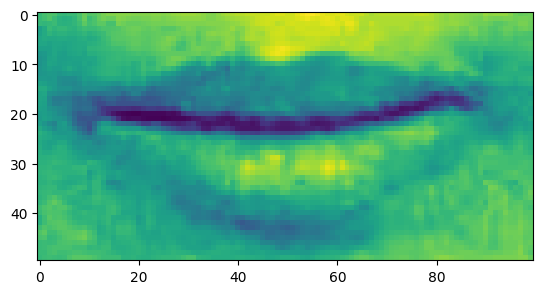

In [617]:
plt.imshow(frames[0])

## get optical flow

In [618]:
def extract_optical_flow(prev_frame, next_frame):

        # Compute optical flow using calcOpticalFlowFarneback
        flow = cv2.calcOpticalFlowFarneback(prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Compute magnitude and angle of flow vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # You can return the computed statistics or features as a tuple or a single vector
        # optical_flow_features = [mean_magnitude, std_magnitude, mean_angle, std_angle]
        # Compute mean and standard deviation of magnitude and angle
        mean_magnitude = np.mean(magnitude)
        std_magnitude = np.std(magnitude)
        mean_angle = np.mean(angle)
        std_angle = np.std(angle)

        # Concatenate mean and standard deviation into a 1D array
        optical_flow_features = np.array([mean_magnitude, std_magnitude, mean_angle, std_angle])

        return optical_flow_features

## get lbp features

In [619]:
def extract_features(frame, prev_frame=None):  # Add prev_frame as optional input parameter

    for frame in frames:
        # Convert frame to grayscale
        #gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Compute LBP features
        lbp = local_binary_pattern(frame, 8, 1, method='uniform')
        hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), range=(0, 59))

        # Compute color histogram features
        #color_hist = cv2.calcHist([frame], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        #color_hist = cv2.normalize(color_hist, color_hist).flatten()

        # Detect facial landmarks
        #landmarks_features = lip_features.flatten()

        # Compute Optical Flow (motion features)
        optical_flow_features = extract_optical_flow(prev_frame, frame) if prev_frame is not None else np.zeros(4)  # Assuming prev_frame is available

        print("Dimensions of hist_lbp:", hist_lbp.shape)
        #print("Dimensions of landmarks_features:", landmarks_features.shape)
        print("Dimensions of optical_flow_features:", optical_flow_features.shape)

        # Concatenate all features
        combined_features = np.concatenate((hist_lbp,  optical_flow_features.reshape(-1))) #landmarks_features,

        print("Dimensions of combined_features:", combined_features.shape)

    return combined_features

# Example usage
#frames = [...]  # Your list of frames
#all_features = extract_features(frames)

## generate columns for each feature

In [620]:
# Define the number of features for each type
num_lbp_features = 59
num_landmarks_features = 2150
num_optical_flow_features = 4

# Generate column names for each feature type
lbp_column_names = [f'lbp_{i}' for i in range(num_lbp_features)]
#landmarks_column_names = [f'landmark_{i}' for i in range(num_landmarks_features)]
optical_flow_column_names = [f'optical_flow_{i}' for i in range(num_optical_flow_features)]

# Concatenate all column names
all_column_names = ['frames'] + lbp_column_names  + optical_flow_column_names #+ landmarks_column_names


In [621]:
all_column_names

['frames',
 'lbp_0',
 'lbp_1',
 'lbp_2',
 'lbp_3',
 'lbp_4',
 'lbp_5',
 'lbp_6',
 'lbp_7',
 'lbp_8',
 'lbp_9',
 'lbp_10',
 'lbp_11',
 'lbp_12',
 'lbp_13',
 'lbp_14',
 'lbp_15',
 'lbp_16',
 'lbp_17',
 'lbp_18',
 'lbp_19',
 'lbp_20',
 'lbp_21',
 'lbp_22',
 'lbp_23',
 'lbp_24',
 'lbp_25',
 'lbp_26',
 'lbp_27',
 'lbp_28',
 'lbp_29',
 'lbp_30',
 'lbp_31',
 'lbp_32',
 'lbp_33',
 'lbp_34',
 'lbp_35',
 'lbp_36',
 'lbp_37',
 'lbp_38',
 'lbp_39',
 'lbp_40',
 'lbp_41',
 'lbp_42',
 'lbp_43',
 'lbp_44',
 'lbp_45',
 'lbp_46',
 'lbp_47',
 'lbp_48',
 'lbp_49',
 'lbp_50',
 'lbp_51',
 'lbp_52',
 'lbp_53',
 'lbp_54',
 'lbp_55',
 'lbp_56',
 'lbp_57',
 'lbp_58',
 'optical_flow_0',
 'optical_flow_1',
 'optical_flow_2',
 'optical_flow_3']

## get lip features

In [622]:
def extract_lip_features(frames):
    # Initialize list to store extracted features for all frames
    all_features = []

    # Initialize prev_frame for computing optical flow
    prev_frame = None

    # Iterate over frames
    for idx, frame in enumerate(frames, start=1):
        # Extract lip features for the current frame
        frame_features = extract_features(frame, prev_frame)  # Pass prev_frame to extract_features

        # Append the frame number to the features
        frame_features = [idx] + frame_features.tolist()

        # Append the features of the current frame to the list
        all_features.append(frame_features)

        # Update prev_frame for computing optical flow in the next iteration
        prev_frame = frame  # No need to convert frame to grayscale since it's already grayscale

    # Create the DataFrame with the actual feature data
    df = pd.DataFrame(all_features, columns=all_column_names)
    #return all_features
    return df

In [623]:
df = extract_lip_features(frames)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
Dimensions of hist_lbp: (59,)
Dimensions of optical_flow_features: (4,)
Dimensions of combined_features: (63,)
D

In [624]:
df

,frames,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,...,lbp_53,lbp_54,lbp_55,lbp_56,lbp_57,lbp_58,optical_flow_0,optical_flow_1,optical_flow_2,optical_flow_3
0,1,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,2,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001063,0.001825,3.008141,1.783733
2,3,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001091,0.002372,3.039797,1.564122
3,4,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000689,0.001185,2.817798,1.719140
4,5,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000632,0.001084,2.730226,1.869915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,64,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001310,0.002886,2.883492,2.074170
64,65,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000803,0.001344,2.579521,1.788151
65,66,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001870,0.003548,3.400491,2.410353
66,67,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000745,0.001196,2.383984,1.679795


In [625]:
df.columns


Index(['frames', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6',
       'lbp_7', 'lbp_8', 'lbp_9', 'lbp_10', 'lbp_11', 'lbp_12', 'lbp_13',
       'lbp_14', 'lbp_15', 'lbp_16', 'lbp_17', 'lbp_18', 'lbp_19', 'lbp_20',
       'lbp_21', 'lbp_22', 'lbp_23', 'lbp_24', 'lbp_25', 'lbp_26', 'lbp_27',
       'lbp_28', 'lbp_29', 'lbp_30', 'lbp_31', 'lbp_32', 'lbp_33', 'lbp_34',
       'lbp_35', 'lbp_36', 'lbp_37', 'lbp_38', 'lbp_39', 'lbp_40', 'lbp_41',
       'lbp_42', 'lbp_43', 'lbp_44', 'lbp_45', 'lbp_46', 'lbp_47', 'lbp_48',
       'lbp_49', 'lbp_50', 'lbp_51', 'lbp_52', 'lbp_53', 'lbp_54', 'lbp_55',
       'lbp_56', 'lbp_57', 'lbp_58', 'optical_flow_0', 'optical_flow_1',
       'optical_flow_2', 'optical_flow_3'],
      dtype='object')

In [626]:
df.head()

,frames,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,...,lbp_53,lbp_54,lbp_55,lbp_56,lbp_57,lbp_58,optical_flow_0,optical_flow_1,optical_flow_2,optical_flow_3
0,1,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,2,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001063,0.001825,3.008141,1.783733
2,3,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001091,0.002372,3.039797,1.564122
3,4,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000689,0.001185,2.817798,1.719140
4,5,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000632,0.001084,2.730226,1.869915


## concat both dfs

In [627]:
import os
import pandas as pd

# Define base path
base_path = "/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/people/samriddhi_10"

# Initialize lists to store data
labels = []
frames = []
sentence_count = 0  # Counter to track the number of processed sentences

for subfolder in os.listdir(base_path):
    subfolder_path = os.path.join(base_path, subfolder)
    sentence_count += 1

    # Skip until the 20th folder
    if sentence_count <= 20:
        continue

    # Read the next 7 folders
    if sentence_count > 21:
        break
    
    if os.path.isdir(subfolder_path):
        # Iterate through sentence folders
        for sentence_folder in os.listdir(subfolder_path):
            sentence_folder_path = os.path.join(subfolder_path, sentence_folder)

            if os.path.isdir(sentence_folder_path):
                # Iterate through picture files
                for file in os.listdir(sentence_folder_path):
                    frame_path = os.path.join(sentence_folder_path, file)

                    # Append label (folder name containing the frame)
                    labels.append(sentence_folder)
                    # Append frame (picture file name)
                    frames.append(file)

# Create dataframe
df2 = pd.DataFrame({'labels': labels, 'frames': frames})

# Print the dataframe
print(df2)


   labels    frames
0   मिर्च  4843.jpg
1   मिर्च  4842.jpg
2   मिर्च  4845.jpg
3   मिर्च  4844.jpg
4   मिर्च  4846.jpg
..    ...       ...
63   रसोई  4812.jpg
64   रसोई  4804.jpg
65   रसोई  4810.jpg
66   रसोई  4811.jpg
67   रसोई  4805.jpg

[68 rows x 2 columns]


import os
import pandas as pd

# Define base path
base_path = "/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/people/"

# Initialize lists to store data
labels = []
frames = []
person = []
sentence_count = 0  # Counter to track the number of processed sentences

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):

        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            #sentence_count += 1

            # Skip until the 19th folder
            #if sentence_count <= 0:
                #continue

            # Read the next 7 folders
            #if sentence_count > 5:
                #break

            if os.path.isdir(subfolder_path):
                # Iterate through sentence folders
                for sentence_folder in os.listdir(subfolder_path):
                    sentence_folder_path = os.path.join(subfolder_path, sentence_folder)

                    if os.path.isdir(sentence_folder_path):
                        # Iterate through picture files
                        for file in os.listdir(sentence_folder_path):
                            frame_path = os.path.join(sentence_folder_path, file)

                            # Append label (folder name containing the frame)
                            labels.append(sentence_folder)
                            # Append frame (picture file name)
                            frames.append(file)
                            person.append(folder)

# Create dataframe
df2 = pd.DataFrame({'labels': labels, 'frames': frames, 'people': person})

# Print the dataframe
print(df2)

In [628]:
import pandas as pd
import os

# Define the path where you want to save the CSV file
output_csv_path = os.path.join("/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/output/", 'person.csv')

# Assuming df is your DataFrame
df2.to_csv(output_csv_path, index=False)

print(f"DataFrame converted and saved to {output_csv_path}")


DataFrame converted and saved to /Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/output/person.csv


In [629]:
df2

,labels,frames
0,मिर्च,4843.jpg
1,मिर्च,4842.jpg
2,मिर्च,4845.jpg
3,मिर्च,4844.jpg
4,मिर्च,4846.jpg
...,...,...
63,रसोई,4812.jpg
64,रसोई,4804.jpg
65,रसोई,4810.jpg
66,रसोई,4811.jpg


In [630]:
df_concat = pd.concat([df2.drop(columns=['labels']), df.drop(columns=['frames'])], axis=1)
#df['frame_number'] = df2['frames']
df_concat = pd.concat([df_concat, df_lip_features.drop(columns=['Frame_Index'])], axis=1)
# Concatenate dataframes side by side
df_concat = pd.concat([df_concat, df2.drop(columns=['frames'])], axis=1)
df_concat

,frames,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,...,Lip_Feature_2,Lip_Feature_3,Lip_Feature_4,Lip_Feature_5,Lip_Feature_6,Lip_Feature_7,Lip_Feature_8,Lip_Feature_9,Lip_Feature_10,labels
0,4843.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,3.000000,2.236068,72.027772,27.000000,41.000000,38.052595,40.112342,27.073973,89.005618,मिर्च
1,4842.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,8.062258,7.071068,73.027392,35.000000,53.000000,52.038447,54.147945,35.128336,91.021975,मिर्च
2,4845.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,2.236068,1.000000,77.058419,22.000000,35.000000,33.015148,36.055513,23.086793,93.085982,मिर्च
3,4844.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,3.000000,2.236068,76.105190,24.000000,37.000000,35.057096,37.054015,24.083189,92.086915,मिर्च
4,4846.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,2.236068,2.236068,81.098705,26.019224,39.000000,37.054015,40.049969,27.073973,96.046864,मिर्च
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,4812.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,5.000000,5.099020,64.195015,33.000000,49.000000,47.010637,49.040799,32.062439,82.152298,रसोई
64,4804.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,10.049876,9.055385,76.164296,32.000000,47.010637,45.044423,47.169906,31.144823,93.193347,रसोई
65,4810.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,2.236068,2.236068,62.201286,31.000000,46.010868,42.047592,45.177428,29.068884,80.224684,रसोई
66,4811.jpg,183.0,361.0,272.0,646.0,1203.0,840.0,408.0,322.0,275.0,...,3.162278,3.162278,65.192024,31.000000,46.010868,44.011362,47.042534,30.066593,81.221918,रसोई


In [631]:
df_concat.columns

Index(['frames', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6',
       'lbp_7', 'lbp_8', 'lbp_9', 'lbp_10', 'lbp_11', 'lbp_12', 'lbp_13',
       'lbp_14', 'lbp_15', 'lbp_16', 'lbp_17', 'lbp_18', 'lbp_19', 'lbp_20',
       'lbp_21', 'lbp_22', 'lbp_23', 'lbp_24', 'lbp_25', 'lbp_26', 'lbp_27',
       'lbp_28', 'lbp_29', 'lbp_30', 'lbp_31', 'lbp_32', 'lbp_33', 'lbp_34',
       'lbp_35', 'lbp_36', 'lbp_37', 'lbp_38', 'lbp_39', 'lbp_40', 'lbp_41',
       'lbp_42', 'lbp_43', 'lbp_44', 'lbp_45', 'lbp_46', 'lbp_47', 'lbp_48',
       'lbp_49', 'lbp_50', 'lbp_51', 'lbp_52', 'lbp_53', 'lbp_54', 'lbp_55',
       'lbp_56', 'lbp_57', 'lbp_58', 'optical_flow_0', 'optical_flow_1',
       'optical_flow_2', 'optical_flow_3', 'Lip_Feature_1', 'Lip_Feature_2',
       'Lip_Feature_3', 'Lip_Feature_4', 'Lip_Feature_5', 'Lip_Feature_6',
       'Lip_Feature_7', 'Lip_Feature_8', 'Lip_Feature_9', 'Lip_Feature_10',
       'labels'],
      dtype='object')

In [632]:
import pandas as pd
import os

# Define the path where you want to save the CSV file
output_csv_path = os.path.join("/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/output/", 'sam20.csv')

# Assuming df is your DataFrame
df_concat.to_csv(output_csv_path, index=False)

print(f"DataFrame converted and saved to {output_csv_path}")


DataFrame converted and saved to /Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/output/sam20.csv


df=pd.read_csv("/Users/samriddhikumari/Desktop/College/symb/SEM_4/SML_prj/output/person.csv")

df

import pandas as pd

# Assuming your DataFrame is named df

# Function to extract the number from the filename
def extract_number(filename):
    try:
        # Extracting the number part of the filename
        number_str = filename.split('.')[0]
        # Check if the number part has four digits
        if number_str.isdigit() and len(number_str) == 4:
            return int(number_str)
        else:
            return None
    except ValueError:
        # If the filename doesn't contain a valid number, return None
        return None

# Sort the DataFrame by the "frames" column to ensure sequential order
df_sorted = df.sort_values(by='frames')

# Initialize variables
expected_number = 1
missing_numbers = []

# Iterate through the frames
for frame in df_sorted['frames']:
    number = extract_number(frame)
    if number is not None:
        if number != expected_number:
            # Number is missing
            missing_numbers.append(expected_number)
        expected_number = number + 1
    else:
        # Print frames that don't contain a four-digit number
        print("Invalid frame:", frame)

# Check for missing numbers beyond the last frame
if expected_number <= 7666:
    missing_numbers.extend(range(expected_number, 7667))

# Print the missing numbers
if missing_numbers:
    print("Missing numbers:", missing_numbers)
else:
    print("All numbers from 1 to 7666 are present.")
